# Another example: Anderson impurity model

The calculation takes about an 10 minutes.

## Hamiltonian

As an example let us solve the Anderson impurity model local with Hamiltonian $H = U\hat{n}_{\uparrow} \hat{n}_{\downarrow} - \mu ( \hat{n}_{\uparrow} + \hat{n}_{\downarrow})$,

In [24]:
from pytriqs.operators import c, c_dag
up, down = 'up', 'dn'
n_up = c_dag(up, 0) * c(up, 0)
n_down = c_dag(down, 0) * c(down, 0)

U = 4
mu = U/2.

H_loc = U * n_up * n_down - mu * (n_up + n_down)

print 'H_loc =', H_loc

H_loc = -2*c_dag('dn',0)*c('dn',0) + -2*c_dag('up',0)*c('up',0) + 4*c_dag('dn',0)*c_dag('up',0)*c('up',0)*c('dn',0)


with 5 bath sites. Parameters of bath sites in ek and V arrays.

In [25]:
from itertools import product
ek = [0]
V =  [-1]
H_hyb=sum(V[i]*(c_dag(s,i+1)*c(s,0)+c_dag(s,0)*c(s,i+1)) for s, i in product(['up','dn'], range(len(ek))))
H_hyb+=sum(ek[i]*(c_dag(s,i+1)*c(s,i+1)) for s, i in product(['up','dn'], range(len(ek))))

In [26]:
H_hyb

-1*c_dag('dn',0)*c('dn',1) + -1*c_dag('dn',1)*c('dn',0) + -1*c_dag('up',0)*c('up',1) + -1*c_dag('up',1)*c('up',0)

## Thermal equilibrium solution

In [27]:
import numpy as np
beta = 50.0 # inverse temperature
fundamental_operators = np.array([[c(up,i), c(down,i)] for i in range(len(ek)+1)]).flatten()

from pyed.TriqsExactDiagonalization import TriqsExactDiagonalization
ed = TriqsExactDiagonalization(H_loc+H_hyb, fundamental_operators, beta)

print r'Z =', ed.get_partition_function()
print 'Omega=', ed.get_free_energy()

Hamiltonian diagonalization:
Z = 1.0
Omega= -3.236067977499788


### Thermal expectation values

In [28]:
print '<n_up>   =', ed.get_expectation_value(n_up)
print '<n_down> =', ed.get_expectation_value(n_down)
print '<n_up * n_down> =', ed.get_expectation_value(n_up * n_down)

<n_up>   = 0.4999999999999998
<n_down> = 0.4999999999999995
<n_up * n_down> = 0.13819660112501048


## Imaginary time single-particle Green's function

100% |########################################################################|


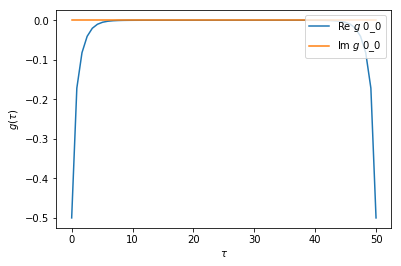

In [29]:
from pytriqs.gf import GfImTime
g_tau = GfImTime(name=r'$g$', beta=beta, statistic='Fermion', n_points=60, indices=[1])    
ed.set_g2_tau(g_tau, c(up,0), c_dag(up,0))

import matplotlib.pyplot as plt
from pytriqs.plot.mpl_interface import oplot
plt.figure(); oplot(g_tau); plt.savefig('figure_g_tau.png')

100% |########################################################################|


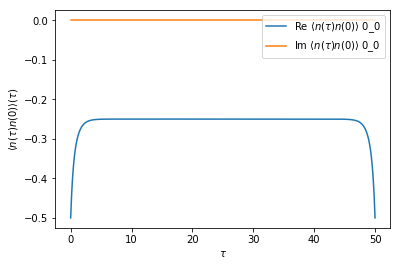

In [30]:
from pytriqs.gf import GfImTime
densdens_tau = GfImTime(name=r'$\langle n(\tau) n(0) \rangle$', beta=beta, statistic='Boson', n_points=1001, indices=[1])    
ed.set_g2_tau(densdens_tau, n_up, n_up)

plt.figure(); oplot(densdens_tau); plt.savefig('figure_densdens_tau.png')

100% |########################################################################|


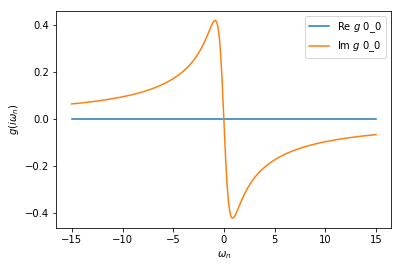

In [31]:
from pytriqs.gf import GfImFreq
g_iwn = GfImFreq(name=r'$g$', beta=beta, statistic='Fermion', n_points=120, indices=[1])
ed.set_g2_iwn(g_iwn, c(up,0), c_dag(up,0))

plt.figure(); oplot(g_iwn); plt.savefig('figure_g_iwn.png')

# Four-operator response functions

In [32]:
from pytriqs.gf import Gf
from pytriqs.gf import MeshImTime, MeshProduct

ntau = 10
imtime = MeshImTime(beta, 'Fermion', ntau)

In [33]:
prodmesh2 = MeshProduct(imtime, imtime)
g3pp_tau = Gf(name=r'$G^{(3)}(\tau_1, \tau_2)$', mesh=prodmesh2, target_shape=[1, 1, 1, 1])
ed.set_g3_tau(g3pp_tau, c(up,0), c_dag(up,0), c(up,0)*c_dag(up,0))

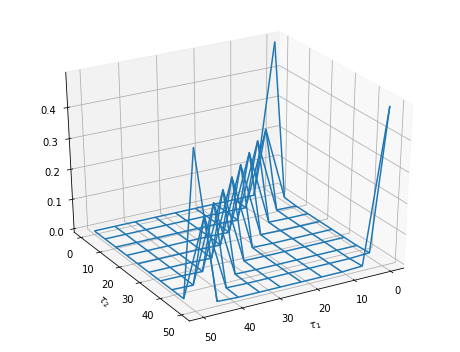

In [34]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(3.25*2, 2*2.5))
ax = fig.add_subplot(1,1,1, projection='3d')

data = g3pp_tau.data[:, :, 0, 0, 0, 0]
tau = [tau.real for tau in g3pp_tau.mesh.components[0]]
t1, t2 = np.meshgrid(tau, tau)
ax.plot_wireframe(t1, t2, data.real)
ax.view_init(30, 60)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
plt.tight_layout()
plt.savefig('figure_g3pp_tau.png')

Text(60.385,0.5,'$\\tau_2$')

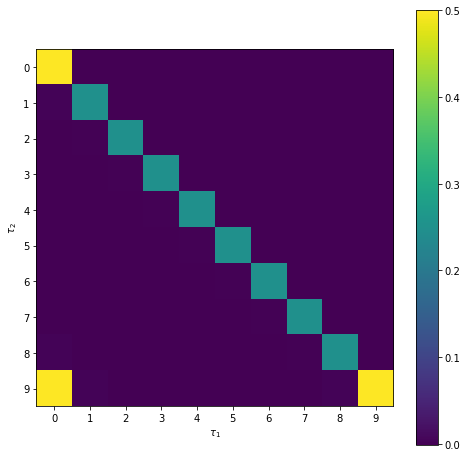

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(data.real)
plt.xticks(range(10))
plt.yticks(range(10))
plt.savefig('im_g3pp_tau.png')
plt.colorbar()
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')

In [ ]:
from pytriqs.applications.impurity_solvers.cthyb import Solver
from pytriqs.gf import *


# Construct the impurity solver with the inverse temperature
# and the structure of the Green's functions
S = Solver(beta = beta, gf_struct = [ ['up',[0]], ['down',[0]] ], n_l = 100)

# Initialize the non-interacting Green's function S.G0_iw
for name, g0 in S.G0_iw: g0 << inverse(iOmega_n+inverse(iOmega_n))

# Run the solver. The results will be in S.G_tau, S.G_iw and S.G_l
S.solve(h_int = U * n_up * n_down,               # Local Hamiltonian
        n_cycles  = 500000,                      # Number of QMC cycles
        length_cycle = 200,                      # Length of one cycle
        n_warmup_cycles = 10000,                 # Warmup cycles
        measure_G_l = True)                      # Measure G_l